In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Cropping2D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD, Adam

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator

In [2]:
## Download: ONLY ONCE!
#os.system('wget https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz')
#os.system('tar xvzf gender.tgz')
#####

In [3]:
# Load 
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Stats
print(x_train.shape)
print(y_train.shape)
print(sum(y_train == 1))
print(sum(y_train == 0))
print("{:.4f}".format(sum(y_train == 1)/y_train.shape[0]))
print(x_test.shape)
print(y_test.shape)
print(sum(y_test == 1))
print(sum(y_test == 0))
print("{:.4f}".format(sum(y_test == 1)/y_test.shape[0]))

(10585, 100, 100, 3)
(10585,)
2381
8204
0.2249
(2648, 100, 100, 3)
(2648,)
596
2052
0.2251


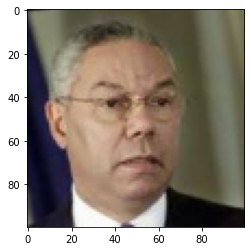

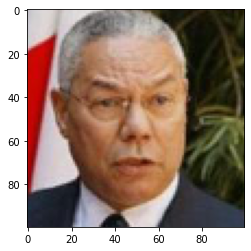

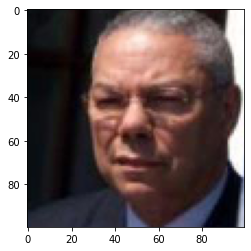

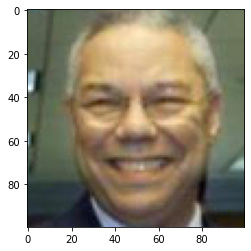

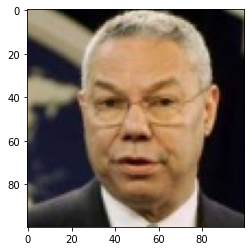

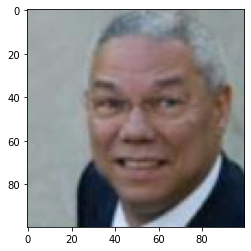

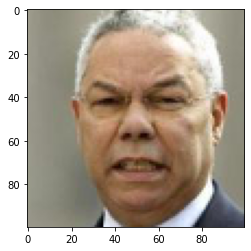

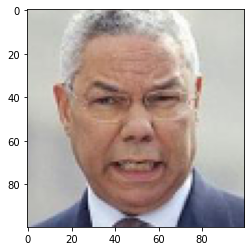

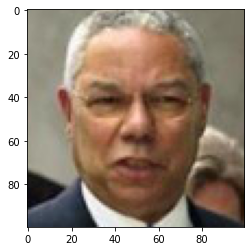

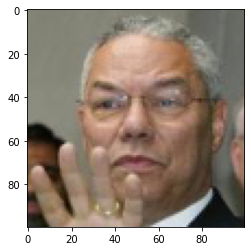

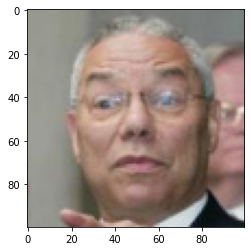

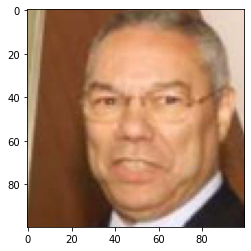

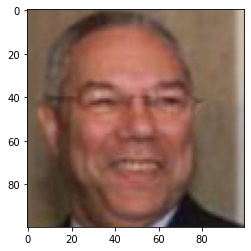

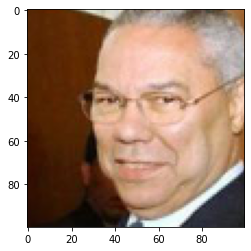

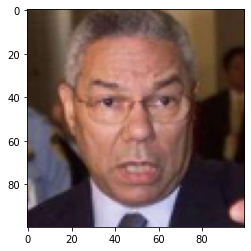

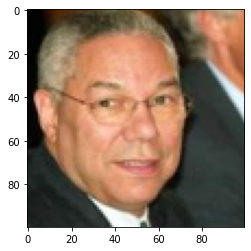

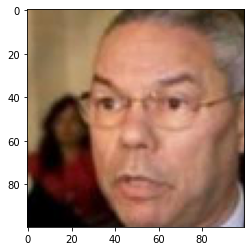

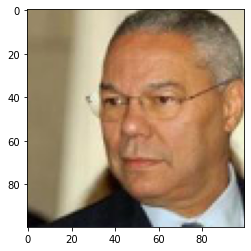

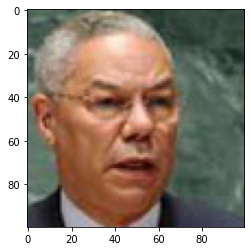

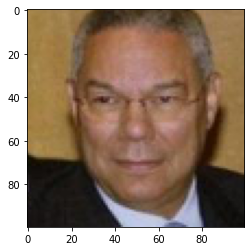

In [4]:
## View some images
for i in range(20):
    plt.imshow(x_train[i,:,:,: ] )
    plt.show()

In [5]:
## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

print(x_train.shape)
print(x_test.shape)

(10585, 100, 100, 3)
(2648, 100, 100, 3)


In [7]:
batch_size = 64
num_classes = 2
epochs = 150

#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=30,
    horizontal_flip=True,
    brightness_range=(0.75, 1.25),
    channel_shift_range=0.2
)

val_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True
)

datagen.fit(x_train)
val_datagen.fit(x_train)

In [8]:
# DEFINE A LEARNING RATE SCHEDULER
def scheduler(epoch):
    if epoch < 20:
        return 0.01
    elif epoch < 40:
        return 0.001
    else:
        return 0.0001
    
set_lr = LRS(scheduler)

In [9]:
inputs = Input(shape=(100, 100, 3))

x = Cropping2D(30)(inputs)
x = keras.layers.experimental.preprocessing.Resizing(32, 32)(x)

x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = BN()(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = BN()(x)

x = MaxPooling2D(2)(x)

x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = BN()(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = BN()(x)

x = MaxPooling2D(2)(x)

x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = BN()(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = BN()(x)

x = MaxPooling2D(2)(x)
x = Dropout(0.25)(x)
x = Flatten()(x)

x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)
  
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
cropping2d (Cropping2D)      (None, 40, 40, 3)         0         
_________________________________________________________________
resizing (Resizing)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128   

In [10]:
opt = SGD()

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)   

## TRAINING with DA and LRA
history = model.fit(
    datagen.flow(x_train, y_train,batch_size=batch_size),
    steps_per_epoch=len(x_train) / batch_size, 
    epochs=epochs,
    validation_data=val_datagen.flow(x_test, y_test, batch_size=batch_size),
    callbacks=[set_lr],
    verbose=1
)

Epoch 1/150
165/165 [==============================] - 41s 235ms/step - loss: 0.6807 - accuracy: 0.6929 - val_loss: 0.5216 - val_accuracy: 0.7757
Epoch 2/150
165/165 [==============================] - 38s 232ms/step - loss: 0.4901 - accuracy: 0.7772 - val_loss: 0.3768 - val_accuracy: 0.7832
Epoch 3/150
165/165 [==============================] - 38s 231ms/step - loss: 0.4492 - accuracy: 0.7879 - val_loss: 0.3401 - val_accuracy: 0.8580
Epoch 4/150
165/165 [==============================] - 39s 233ms/step - loss: 0.4142 - accuracy: 0.8078 - val_loss: 0.3052 - val_accuracy: 0.8554
Epoch 5/150
165/165 [==============================] - 39s 237ms/step - loss: 0.3882 - accuracy: 0.8249 - val_loss: 0.2833 - val_accuracy: 0.8784
Epoch 6/150
165/165 [==============================] - 39s 234ms/step - loss: 0.3526 - accuracy: 0.8437 - val_loss: 0.2688 - val_accuracy: 0.8988
Epoch 7/150
165/165 [==============================] - 39s 237ms/step - loss: 0.3413 - accuracy: 0.8576 - val_loss: 0.3044 -

KeyboardInterrupt: 